In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from transformers import DeiTForImageClassification, DeiTConfig
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm  # Para la barra de progreso
import os
from PIL import Image
from torchsummary import summary
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
!pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# @title Data Loading
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

modelsdir = '/content/drive/MyDrive/combined'

datasetdir = '/content/drive/MyDrive/cbis-ddsm'
X_train_1 = torch.load(datasetdir + "/X_train_balanced.pt")
y_train_1 = torch.load(datasetdir + "/y_train_balanced.pt")
X_test_1 = torch.load(datasetdir + "/X_test.pt")
y_test_1 = torch.load(datasetdir + "/y_test.pt")

X_tensor = torch.load("/content/drive/MyDrive/output/X_oversampled.pt")
y_tensor = torch.load("/content/drive/MyDrive/output/y_oversampled.pt")

from sklearn.model_selection import train_test_split
test_size = 0.2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

X_train_full = torch.cat((X_train_1, X_train_2), dim=0)
y_train_full = torch.cat((y_train_1, y_train_2), dim=0)
X_test_full = torch.cat((X_test_1, X_test_2), dim=0)
y_test_full = torch.cat((y_test_1, y_test_2), dim=0)

X_train = X_train_full
y_train = y_train_full
X_test = X_test_full
y_test = y_test_full

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

print('X train shape : {}' .format(X_train.shape))
print('y train shape : {}' .format(y_train.shape))
print('X test shape : {}' .format(X_test.shape))
print('y test shape : {}' .format(y_test.shape))

X train shape : torch.Size([9916, 1, 224, 224])
y train shape : torch.Size([9916])
X test shape : torch.Size([2060, 1, 224, 224])
y test shape : torch.Size([2060])


In [ ]:
# @title Early Stopping
## Definición de clase para el callback "Early Stopping" con guardado de modelo
class EarlyStopping:
    def __init__(self, path, patience=3, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = float('inf')
        self.path = path  # Archivo donde guardaremos el modelo

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping no mejoró por {self.counter} épocas')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Pérdida de validación mejorada a {val_loss:.6f}. Guardando modelo...')
            torch.save(model, self.path)  # Guardamos el modelo a fichero
            self.val_loss_min = val_loss


In [ ]:
# @title Training Function
def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping, transforms):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        correct_train = 0
        total_train = 0

        model.train()

        # Bucle de entrenamiento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            if transforms:
                transformed_images = torch.stack([transforms(image) for image in images])
                images, labels = transformed_images.to(device), labels.to(device)
            else:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Precisión del entrenamiento
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Promedio de pérdida y precisión del entrenamiento
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Guardar métricas de entrenamiento
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()  # Modo de evaluación
        val_loss = 0
        correct_val = 0
        total_val = 0


        with torch.no_grad():  # Sin cálculos de gradientes durante la validación
          for images, labels in val_loader:
            if transforms:
                transformed_images = torch.stack([transforms(image) for image in images])
                images, labels = transformed_images.to(device), labels.to(device)
            else:
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

          # Precisión de validación
          _, predicted = torch.max(outputs, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Guardar métricas de validación
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()  # Tiempo al final de la época
        epoch_duration = end_time - start_time  # Duración de la época

        # resultados
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping activado. Proceso detenido!")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# @title Métricas y gráficas
def metrics(model, test_loader, transforms):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()

  all_preds = []
  all_labels = []

  for images, labels in test_loader:
      if transforms:
          transformed_images = torch.stack([transforms(image) for image in images])
          images, labels = transformed_images.to(device), labels.to(device)
      else:
          images, labels = images.to(device), labels.to(device)

      with torch.no_grad():
          outputs = model(images)

      _, predicted = torch.max(outputs, 1)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  conf_matrix = confusion_matrix(all_labels, all_preds)

  plt.figure(figsize=(4, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Cáncer', 'Con Cáncer'], yticklabels=['Sin Cáncer', 'Con Cáncer'])
  plt.xlabel('Predicciones')
  plt.ylabel('Verdadero')
  plt.title('Matriz de Confusión')
  plt.show()

  accuracy = accuracy_score(all_labels, all_preds)  # Precisión global
  report = classification_report(all_labels, all_preds, target_names=['Sin Cáncer', 'Con Cáncer'])

  print(f"Precisión global: {accuracy * 100:.2f}%")
  print("Informe y métricas de clasificación:")
  print(report)

  # Calcular métricas principales usando las listas de etiquetas y predicciones
  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  accuracy = accuracy_score(all_labels, all_preds)

  # Imprimir las métricas calculadas
  print(f"Precisión: {precision:.2f}")
  print(f"Sensibilidad (Recall): {recall:.2f}")
  print(f"F1-Score: {f1:.2f}")
  print(f"Accuracy: {accuracy:.2f}")

  # Calcular especificidad usando la matriz de confusión
  true_negatives = conf_matrix[0, 0]
  false_positives = conf_matrix[0, 1]
  true_positives = conf_matrix[1, 0]
  false_negatives = conf_matrix[1, 1]

  specificity = true_negatives / (true_negatives + false_positives)

  print(f"Especificidad: {specificity:.2f}")

def graphLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model Loss')
  plt.legend(loc='upper left')
  plt.show()

  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Val Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from timm import create_model

transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repetir el canal de escala de grises para obtener 3 canales
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = create_model('deit_base_patch16_224', pretrained=True, num_classes=2)
model = model.cuda()

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

fichModelo = modelsdir + '/Deit.pth'
eaStop = EarlyStopping(fichModelo, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/30: 100%|██████████| 619/619 [02:22<00:00,  4.36it/s]


Epoch [1/30], Train Loss: 0.710, Train Accuracy: 50.23%, Val Loss: 0.6923, Val Accuracy: 56.25%, Time: 152.32 seconds
Pérdida de validación mejorada a 0.692283. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [02:25<00:00,  4.25it/s]


Epoch [2/30], Train Loss: 0.694, Train Accuracy: 51.04%, Val Loss: 0.6911, Val Accuracy: 56.25%, Time: 155.80 seconds
Pérdida de validación mejorada a 0.691135. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [3/30], Train Loss: 0.693, Train Accuracy: 52.01%, Val Loss: 0.6962, Val Accuracy: 43.75%, Time: 158.78 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [4/30], Train Loss: 0.696, Train Accuracy: 51.33%, Val Loss: 0.6937, Val Accuracy: 43.75%, Time: 158.79 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 5/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [5/30], Train Loss: 0.694, Train Accuracy: 51.23%, Val Loss: 0.6958, Val Accuracy: 43.75%, Time: 158.85 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 6/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [6/30], Train Loss: 0.692, Train Accuracy: 52.36%, Val Loss: 0.6922, Val Accuracy: 68.75%, Time: 158.83 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 7/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [7/30], Train Loss: 0.692, Train Accuracy: 52.25%, Val Loss: 0.6915, Val Accuracy: 68.75%, Time: 158.75 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 8/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [8/30], Train Loss: 0.690, Train Accuracy: 53.07%, Val Loss: 0.7019, Val Accuracy: 43.75%, Time: 158.79 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 9/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [9/30], Train Loss: 0.690, Train Accuracy: 52.38%, Val Loss: 0.6878, Val Accuracy: 68.75%, Time: 158.75 seconds
Pérdida de validación mejorada a 0.687801. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [10/30], Train Loss: 0.691, Train Accuracy: 52.78%, Val Loss: 0.6936, Val Accuracy: 68.75%, Time: 158.74 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 11/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [11/30], Train Loss: 0.689, Train Accuracy: 53.16%, Val Loss: 0.7216, Val Accuracy: 37.50%, Time: 158.75 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 12/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [12/30], Train Loss: 0.688, Train Accuracy: 53.06%, Val Loss: 0.6930, Val Accuracy: 62.50%, Time: 158.75 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 13/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [13/30], Train Loss: 0.689, Train Accuracy: 52.59%, Val Loss: 0.6915, Val Accuracy: 62.50%, Time: 158.75 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 14/30: 100%|██████████| 619/619 [02:28<00:00,  4.17it/s]


Epoch [14/30], Train Loss: 0.688, Train Accuracy: 53.00%, Val Loss: 0.6983, Val Accuracy: 68.75%, Time: 158.73 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 15/30: 100%|██████████| 619/619 [02:28<00:00,  4.18it/s]


Epoch [15/30], Train Loss: 0.686, Train Accuracy: 53.54%, Val Loss: 0.6999, Val Accuracy: 56.25%, Time: 158.35 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 16/30: 100%|██████████| 619/619 [02:28<00:00,  4.18it/s]


Epoch [16/30], Train Loss: 0.688, Train Accuracy: 52.78%, Val Loss: 0.6920, Val Accuracy: 68.75%, Time: 158.33 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 17/30: 100%|██████████| 619/619 [02:28<00:00,  4.18it/s]


Epoch [17/30], Train Loss: 0.693, Train Accuracy: 51.74%, Val Loss: 0.7295, Val Accuracy: 56.25%, Time: 158.39 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 18/30:  99%|█████████▊| 610/619 [02:26<00:02,  4.17it/s]


KeyboardInterrupt: 

In [ ]:
models_list.append("DeiT");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader, transform)

NameError: name 'train_loss' is not defined

In [ ]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.cat([X_train, X_train, X_train], dim=1)
X_test = torch.cat([X_test, X_test, X_test], dim=1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

# Cargar el modelo ViT preentrenado
model = models.vit_b_16(pretrained=True)

# Adaptar capa final a las 2 salidas necesarias
num_features = model.heads.head.in_features
model.heads = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

import time
from tqdm import tqdm

# Entrenamiento básico
num_epochs = 5
for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        progress_bar.set_postfix({'Loss': loss.item()})

    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    progress_bar.close()

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2f} seconds")

In [ ]:
# Evaluación
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluation', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print("Test Accuracy:", accuracy)

Evaluation: 100%|██████████| 26/26 [00:05<00:00,  5.07it/s]

Test Accuracy: 0.6346153846153846


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)  # Aplanar en el eje de las características
        x = x.transpose(1, 2)  # Transponer para obtener la forma [batch, num_patches, embed_dim]
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super(PositionalEncoding, self).__init__()
        # Crear embeddings posicionales sin entrenar
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

    def forward(self, x):
        return x + self.position_embeddings[:, :x.size(1)]  # Ajustar el tamaño

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        # Self-attention requiere que el tensor tenga la forma [num_patches, batch, embed_dim]
        x = x.transpose(0, 1)  # Transponer para la atención
        x, _ = self.attention(x, x, x)
        return x.transpose(0, 1)  # Volver a la forma original

class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.linear2(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.feedforward = FeedForward(embed_dim, hidden_dim, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Bloque de atención con conexión residual
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)

        # Bloque de feedforward con conexión residual
        ff_output = self.feedforward(x)
        return self.norm2(x + ff_output)

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, hidden_dim, num_classes, num_layers):
        super(VisionTransformer, self).__init__()
        # Embeddings de parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Positional encoding
        num_patches = self.patch_embedding.num_patches
        self.positional_encoding = PositionalEncoding(embed_dim, num_patches)

        # Bloques del Transformer
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim) for _ in range(num_layers)
        ])

        # Clasificación
        self.norm = nn.LayerNorm(embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Token de clasificación
        self.linear = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Obtener embeddings de parches
        x = self.patch_embedding(x)

        # Añadir positional encoding y token de clasificación
        batch_size = x.shape[0]
        cls_token = self.cls_token.repeat(batch_size, 1, 1)
        x = torch.cat([cls_token, x], dim=1)  # Agregar token de clasificación
        x = self.positional_encoding(x)

        # Pasar por los bloques del Transformer
        for block in self.blocks:
            x = block(x)

        # Usar solo el token de clasificación para la salida final
        x = self.norm(x[:, 0])  # Seleccionar el primer token
        return self.linear(x)

In [ ]:
# Configuración del modelo
img_size = 224
patch_size = 16  # Tamaño de los parches
embed_dim = 768  # Dimensión de los embeddings
num_heads = 12
hidden_dim = 3072  # Dimensión de la red feedforward
num_layers = 12  # Número de bloques del Transformer
num_classes = 2

vit = VisionTransformer(img_size, patch_size, 1, embed_dim, num_heads, hidden_dim, num_classes, num_layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (positional_encoding): PositionalEncoding()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (feedforward): FeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# Función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        progress_bar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', position=0, leave=True)

        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)

            progress_bar.set_postfix({'Train Loss': loss.item()})
            progress_bar.update()

        progress_bar.close()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train_predictions / total_train_predictions

        val_accuracy = evaluate_model(model, val_loader, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = model.state_dict()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f} seconds")

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()  # Poner el modelo en modo de evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16)

learning_rate = 0.001
num_epochs = 10
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(vit, criterion, optimizer, train_loader, val_loader, num_epochs, device)

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
test_acc = evaluate_model(trained_model, test_loader, device)
print("Test Accuracy:", test_acc)

Epoch 1/10: 100%|██████████| 620/620 [02:43<00:00,  3.78it/s, Train Loss=0.75]


Epoch 1/10, Train Loss: 0.7354, Train Acc: 0.4924, Val Acc: 0.5316
Epoch 1/10, Time: 175.11 seconds


Epoch 2/10: 100%|██████████| 620/620 [02:44<00:00,  3.77it/s, Train Loss=0.684]


Epoch 2/10, Train Loss: 0.6960, Train Acc: 0.4936, Val Acc: 0.5316
Epoch 2/10, Time: 175.77 seconds


Epoch 3/10: 100%|██████████| 620/620 [02:44<00:00,  3.77it/s, Train Loss=0.697]


Epoch 3/10, Train Loss: 0.6941, Train Acc: 0.4930, Val Acc: 0.5316
Epoch 3/10, Time: 175.78 seconds


Epoch 4/10: 100%|██████████| 620/620 [02:44<00:00,  3.77it/s, Train Loss=0.691]


Epoch 4/10, Train Loss: 0.6935, Train Acc: 0.4864, Val Acc: 0.5316
Epoch 4/10, Time: 175.77 seconds


Epoch 5/10:  70%|███████   | 435/620 [01:55<00:49,  3.76it/s, Train Loss=0.694]

KeyboardInterrupt: 

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        progress_bar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', position=0, leave=True)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)

            progress_bar.set_postfix({'Train Loss': loss.item()})
            progress_bar.update()

        progress_bar.close()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train_predictions / total_train_predictions
        val_accuracy = evaluate_model(model, val_loader, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model

# Función de evaluación
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular precisión
    acc = accuracy_score(all_labels, all_preds)
    return acc

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)

# Entrenar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(vit, criterion, optimizer, train_loader, val_loader, num_epochs, device)

# Evaluar el modelo
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
test_acc = evaluate_model(trained_model, test_loader, device)
print("Test Accuracy:", test_acc)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# Función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        progress_bar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', position=0, leave=True)

        start_time = time.time()

        # Bucle de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)

            progress_bar.set_postfix({'Train Loss': loss.item()})
            progress_bar.update()

        progress_bar.close()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train_predictions / total_train_predictions

        val_accuracy = evaluate_model(model, val_loader, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = model.state_dict()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f} seconds")

    model.load_state_dict(best_model_wts)
    return model

# Función de evaluación
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)

# Entrenar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(vit, criterion, optimizer, train_loader, val_loader, num_epochs, device)

# Evaluar
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
test_acc = evaluate_model(trained_model, test_loader, device)
print("Test Accuracy:", test_acc)

NameError: name 'batch_size' is not defined

Test Accuracy: 0.7790585975024016


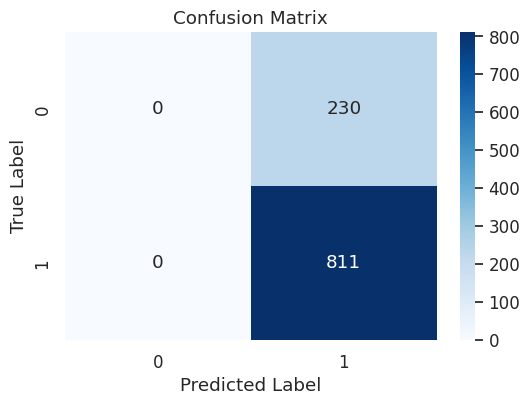

Accuracy: 0.7791
Precision: 0.7791
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1 Score: 0.8758


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_metrics_from_confusion_matrix(cm):
    # Calcular métricas
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Mostrar métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

# Función para mostrar la matriz de confusión y las métricas con Seaborn
def show_metrics_with_seaborn(model, X_test, y_test):
    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular métricas a partir de la matriz de confusión
    calculate_metrics_from_confusion_matrix(cm)

# Evaluar el modelo en conjunto de prueba
test_acc = evaluate_model(trained_model, X_test, y_test)
print("Test Accuracy:", test_acc)

X_test = X_test.to(device)
y_test = y_test.to(device)
# Mostrar matriz de confusión y métricas con Seaborn
show_metrics_with_seaborn(trained_model, X_test, y_test)

